In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

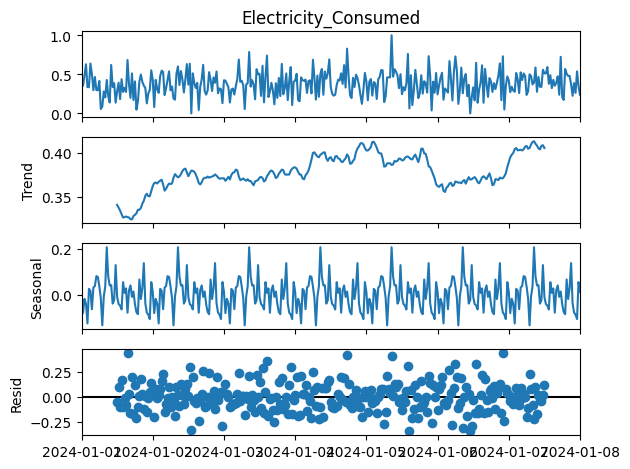

In [2]:
df = pd.read_csv(
    r'C:\Users\Jaum\Downloads\smart_meter_data.csv',
    parse_dates=['Timestamp'],
    index_col='Timestamp'
)
serie = (
    df['Electricity_Consumed']
    .astype(float)
    .asfreq('30min')
)

decompose = seasonal_decompose(serie[:337], model='additive', period=48)
decompose.plot()
plt.tight_layout()

In [3]:
df_feat = pd.DataFrame(index=serie.index)
df_feat['consumo']      = serie
df_feat['hour']         = serie.index.hour
df_feat['sin_hour']     = np.sin(2*np.pi * df_feat['hour'] / 24)
df_feat['cos_hour']     = np.cos(2*np.pi * df_feat['hour'] / 24)
df_feat['dow']          = serie.index.dayofweek
df_feat['sin_dow']      = np.sin(2*np.pi * df_feat['dow']  / 7)
df_feat['cos_dow']      = np.cos(2*np.pi * df_feat['dow']  / 7)
df_feat['lag_48']       = df_feat['consumo'].shift(48)
df_feat['roll_mean_48'] = df_feat['consumo'].rolling(48).mean().shift(1)
df_feat['roll_std_48']  = df_feat['consumo'].rolling(48).std().shift(1)
df_feat.dropna(inplace=True)

features = [
    'consumo','lag_48','roll_mean_48','roll_std_48',
    'sin_hour','cos_hour','sin_dow','cos_dow'
]
data = df_feat[features].values   # shape=(n_samples,8)

In [4]:
freq_per_day = 48
train_n = 7 * freq_per_day
horizon = 3 * freq_per_day

serie_full   = df_feat['consumo']
train_series = serie_full.iloc[:train_n]
test_series  = serie_full.iloc[train_n:train_n + horizon]

train_data = data[:train_n]

scaler       = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)

In [5]:
hw_model    = ExponentialSmoothing(
    train_series,
    trend='add',
    seasonal='add',
    seasonal_periods=48
).fit()
hw_forecast = hw_model.forecast(horizon)

In [6]:
arima_model    = ARIMA(
    train_series,
    order=(1,1,1),
    seasonal_order=(1,0,1,48)
).fit()
arima_forecast = arima_model.forecast(horizon)

In [7]:
def create_dataset_multivariate(arr, look_back=96):
    X, y = [], []
    for i in range(look_back, len(arr)):
        X.append(arr[i-look_back:i, :])
        y.append(arr[i, 0])
    return np.array(X), np.array(y)

look_back = 48
X_train, y_train = create_dataset_multivariate(train_scaled, look_back)

In [8]:
n_features = X_train.shape[2]

model = Sequential([
    Input((look_back, n_features)),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [9]:
es = EarlyStopping('val_loss', patience=50, restore_best_weights=True)
model.fit(
    X_train, y_train,
    epochs=500, batch_size=8,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - loss: 0.0601 - val_loss: 0.0261
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 0.0264 - val_loss: 0.0251
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.0303 - val_loss: 0.0281
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0263 - val_loss: 0.0362
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0249 - val_loss: 0.0293
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0278 - val_loss: 0.0252
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0278 - val_loss: 0.0319
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0306 - val_loss: 0.0262
Epoch 10/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0242 - val_loss: 0.0286
Epoch 11/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0284 - val_loss: 0.0266
Epoch 12/500
33/33 ━━━━━━━━━━━━━━━━━━━━

In [10]:
# preparar listas para as previsões no nível bruto
past_raw = df_feat['consumo'].iloc[:train_n].tolist()
future_preds = []

# a cada passo, montamos o vetor de 8 features bruto e escalamos
for step in range(horizon):
    # timestamp futuro
    ts = df_feat.index[train_n - 1] + pd.Timedelta(minutes=30*(step+1))

    # features de hora e dia
    h  = ts.hour
    dow = ts.dayofweek
    sin_h = np.sin(2*np.pi * h/24)
    cos_h = np.cos(2*np.pi * h/24)
    sin_d = np.sin(2*np.pi * dow/7)
    cos_d = np.cos(2*np.pi * dow/7)

    # consumo lag_48: há 48 passos atrás no raw
    if len(past_raw) >= 48:
        lag48 = past_raw[-48]
    else:
        lag48 = past_raw[0]

    # rollings de 48 últimos raw
    window = np.array(past_raw[-48:])
    roll_mean = window.mean()
    roll_std  = window.std()

    # vetor bruto de input
    x_raw = np.array([
        past_raw[-1],  # consumo "atual"
        lag48,
        roll_mean,
        roll_std,
        sin_h,
        cos_h,
        sin_d,
        cos_d
    ]).reshape(1, -1)

    # escalonar
    x_scaled = scaler.transform(x_raw)  # shape (1,8)

    last_window = np.vstack([train_scaled, *future_preds]) if False else None

    try:
        full_scaled
    except NameError:
        full_scaled = train_scaled.copy()

    full_scaled = np.vstack([full_scaled, x_scaled])

    seq = full_scaled[-look_back:, :].reshape(1, look_back, n_features)
    pred_s = model.predict(seq, verbose=0)[0,0]
    future_preds.append(pred_s)
    past_raw.append(float(scaler.inverse_transform(
        np.hstack([pred_s, np.zeros(n_features-1)]).reshape(1,-1)
    )[:,0]))


C:\Users\Jaum\AppData\Local\Temp\ipykernel_6124\4068978605.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  past_raw.append(float(scaler.inverse_transform(
C:\Users\Jaum\AppData\Local\Temp\ipykernel_6124\4068978605.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  past_raw.append(float(scaler.inverse_transform(
C:\Users\Jaum\AppData\Local\Temp\ipykernel_6124\4068978605.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  past_raw.append(float(scaler.inverse_

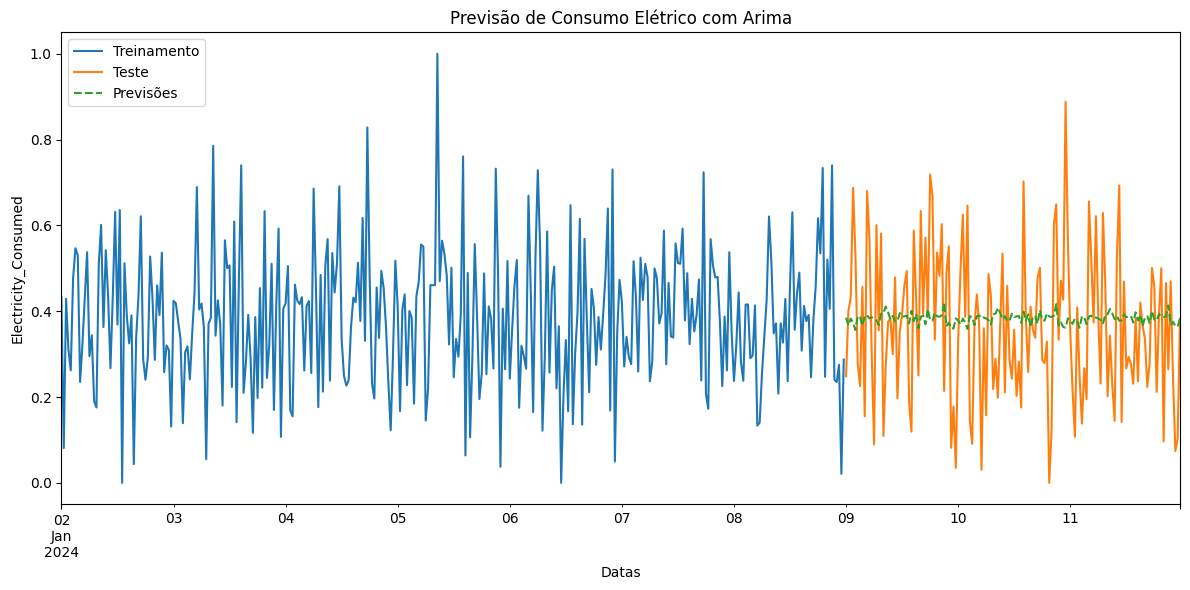

In [11]:
plt.figure(figsize=(12,6))
train_series.plot(label='Treinamento')
test_series.plot(label='Teste')
arima_forecast.plot(label='Previsões', linestyle='--')
plt.title(f'Previsão de Consumo Elétrico com Arima')
plt.ylabel('Electricity_Consumed')
plt.xlabel('Datas')
plt.legend()
plt.tight_layout()
plt.show()

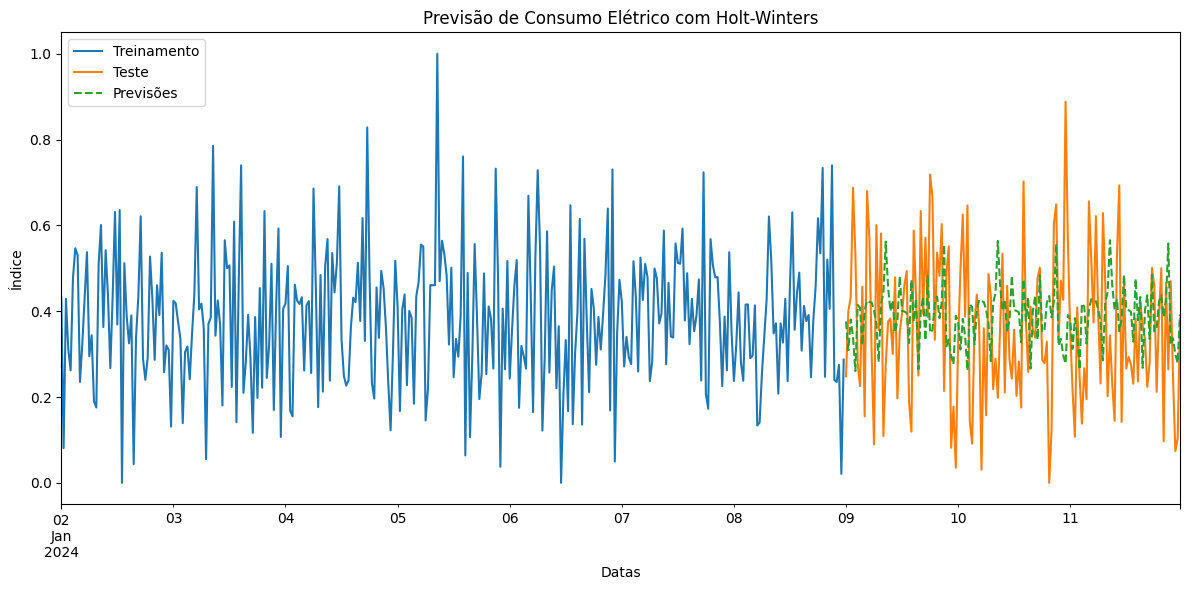

In [12]:
plt.figure(figsize=(12,6))
train_series.plot(label='Treinamento')
test_series.plot(label='Teste')
hw_forecast.plot(label='Previsões', linestyle='--')
plt.title('Previsão de Consumo Elétrico com Holt-Winters')
plt.ylabel('Índice')
plt.xlabel('Datas')
plt.legend()
plt.tight_layout()
plt.show()

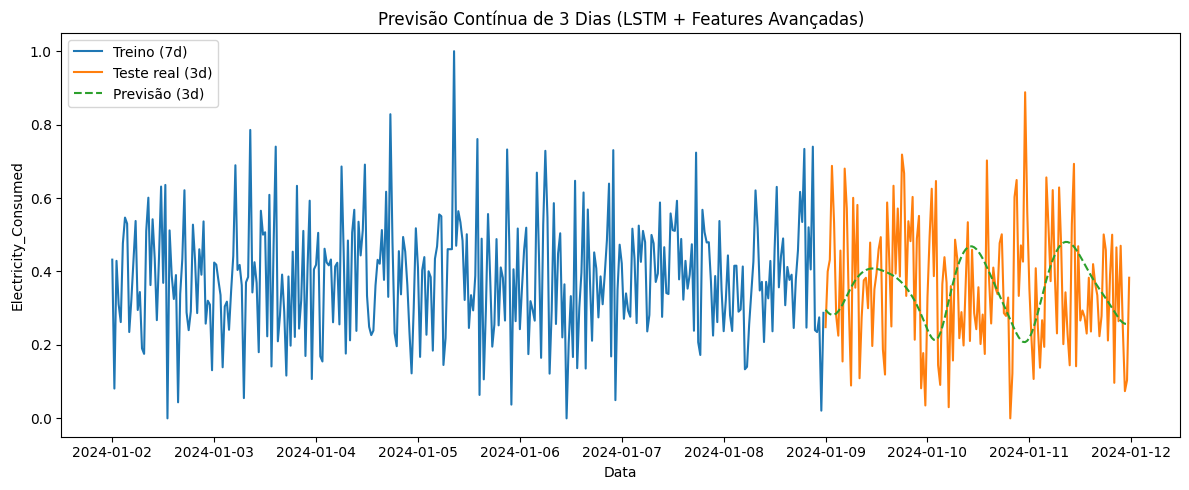

In [13]:
# datas do horizonte (3 dias, 144 passos de 30 min)
future_index = [
    df_feat.index[train_n - 1] + pd.Timedelta(minutes=30*(i+1))
    for i in range(horizon)
]

# extrai valores reais para esses 3 dias
real_values = df_feat['consumo'].iloc[train_n:train_n + horizon].values

# converte previsões para escala original
dummy = np.zeros((len(future_preds), n_features))
dummy[:, 0] = future_preds
pred_full = scaler.inverse_transform(dummy)[:, 0]

# plota tudo junto
plt.figure(figsize=(12,5))
plt.plot(df_feat.index[:train_n], df_feat['consumo'].iloc[:train_n], label='Treino (7d)')
plt.plot(future_index, real_values,            label='Teste real (3d)')
plt.plot(future_index, pred_full, linestyle='--', label='Previsão (3d)')
plt.title('Previsão Contínua de 3 Dias (LSTM + Features Avançadas)')
plt.xlabel('Data')
plt.ylabel('Electricity_Consumed')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Função do MAPE
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Cálculo dos MAPEs
print('MAPE Holt-Winters:', MAPE(test_series, hw_forecast))
print('MAPE ARIMA:', MAPE(test_series, arima_forecast))
print('MAPE LSTM:', MAPE(real_values, pred_full))

MAPE Holt-Winters: 76.41786082698991
MAPE ARIMA: 71.65538986069998
MAPE LSTM: 64.79207738404008
